In [1]:
import numpy as np
import theano
import theano.tensor as T
import pandas as pd

from theano.tensor.shared_randomstreams import RandomStreams
from theano.tensor.nnet.bn import batch_normalization_train, batch_normalization_test
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('./train.csv')

In [3]:
# Load data

data = df.values.astype(np.float32)
np.random.shuffle(data)
X = data[:, 1:]
Y = data[:, 0]

Xtrain = X[:-1000]
Ytrain = Y[:-1000]
Xtest  = X[-1000:]
Ytest  = Y[-1000:]

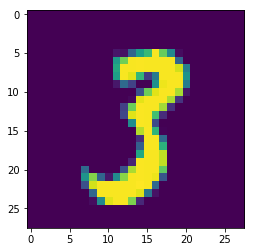

In [4]:
s = np.reshape(Xtrain[0], (28, 28))
plt.imshow(s)
plt.show()

In [5]:
# normalizie the data

mu = Xtrain.mean(axis=0)
std = Xtrain.std(axis=0)

np.place(std, std == 0, 1)

Xtrain = (Xtrain - mu) / std
Xtest = (Xtest - mu) / std

In [6]:
# change y to hot encoder

def y2indicator(y):

    y = y.astype(np.int32)
    ind = np.zeros((len(y), 10))

    for i in range(len(y)):
        ind[i, y[i]] = 1
        
    return ind 

In [7]:
def error_rate(p, t):
    return np.mean(p != t)

In [8]:
def relu(a):
    return a * (a > 0)

In [9]:
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

In [10]:
# data is ready

Xtrain = Xtrain.astype(np.float32)
Xtest = Xtest.astype(np.float32)
Ytrain = Ytrain.astype(np.float32)
Ytest = Ytest.astype(np.float32)
Ytrain_ind = Ytrain_ind.astype(np.float32)
Ytest_ind = Ytest_ind.astype(np.float32)

In [11]:
# initial values

max_iter = 15
print_period = 100

lr = 0.0004
reg = 0.01 #smooth parameter

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

M = 300
K = 10

In [12]:
W1_init = np.random.randn(D, M) / 28
b1_init = np.zeros(M)
W2_init = np.random.randn(M, K) / np.sqrt(M)
b2_init = np.zeros(K)

In [31]:
# step 2: define theano variables and expressions
thX = T.matrix('X')
thT = T.matrix('T')
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')

In [32]:
# we can use the built-in theano functions to do relu and softmax

thZ = relu( thX.dot(W1) + b1 )  
thY = T.nnet.softmax( thZ.dot(W2) + b2 )


Dropout

In [33]:
# dropout 
"""
rng = RandomStreams()

mask1_thX = rng.binomial(n=1, p = 0.8, size = thX.shape)
thX = thX * mask1_thX


thZ = relu( thX.dot(W1) + b1 )  

mask1_thZ = rng.binomial(n=1, p = 0.5, size = thZ.shape)
thZ = thZ * mask1_thZ

thY = T.nnet.softmax( thZ.dot(W2) + b2 )
"""

'\nrng = RandomStreams()\n\nmask1_thX = rng.binomial(n=1, p = 0.8, size = thX.shape)\nthX = thX * mask1_thX\n\n\nthZ = relu( thX.dot(W1) + b1 )  \n\nmask1_thZ = rng.binomial(n=1, p = 0.5, size = thZ.shape)\nthZ = thZ * mask1_thZ\n\nthY = T.nnet.softmax( thZ.dot(W2) + b2 )\n'

Regularization

In [34]:
# define the cost function and prediction
cost = -(thT * T.log(thY)).sum()

#L1 regularization
#cost = -(thT * T.log(thY)).sum() + reg*((W1*W1).sum() + (b1*b1).sum() + (W2*W2).sum() + (b2*b2).sum())

#L2 regularization
#cost = -(thT * T.log(thY)).sum() + reg*(np.abs(W1).sum() + np.abs(b1).sum() + np.abs(W2).sum() + np.abs(b2).sum())

prediction = T.argmax(thY, axis=1)

Momentum

In [41]:
""" 

mu = 0.9
""" 
#without momentum 



update_W1 = W1 - lr*T.grad(cost, W1)
update_b1 = b1 - lr*T.grad(cost, b1)
update_W2 = W2 - lr*T.grad(cost, W2)
update_b2 = b2 - lr*T.grad(cost, b2)

updates = [(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)]



# this is equivalent to the line above
"""
params = [W1, b1, W2, b2]
updates = [(p, p-lr*T.grad(cost, p)) for p in params]
"""

# using for loop 
"""
params = [W1, b1, W2, b2]
updates = []
for p in params:
    update_p = p - lr * T.grad(cost, p)
    updates.append((p, update_p))

#With momentum
"""
"""

vW1_init = np.zeros((D,M))
vb1_init = np.zeros(M)
vW2_init = np.zeros((M,K))
vb2_init = np.zeros(K)

vW1 = theano.shared(vW1_init, 'dW1')
vb1 = theano.shared(vb1_init, 'db1')
vW2 = theano.shared(vW2_init, 'dW2')
vb2 = theano.shared(vb2_init, 'db2')

update_vW1 = mu * vW1 - lr * T.grad(cost, W1)
update_vb1 = mu * vb1 - lr * T.grad(cost, b1)
update_vW2 = mu * vW2 - lr * T.grad(cost, W2)
update_vb2 = mu * vb2 - lr * T.grad(cost, b2)

update_W1 = W1 + update_vW1
update_b1 = b1 + update_vb1
update_W2 = W2 + update_vW2
update_b2 = b2 + update_vb2

updates = [(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)] + [(vW1, update_vW1), (vb1, update_vb1), (vW2, update_vW2), (vb2, update_vb2)]


# this is equivalent to the line above

params = [W1, b1, W2, b2]
vparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]

updates = [(p, p + mu * vp -lr * T.grad(cost, p)) for p, vp in zip(params, vparams)] + [(vp, mu * vp - lr * T.grad(cost, p)) for p, vp in zip(params, vparams)]


#using for loops
mu = 0.9


params = [W1, b1, W2, b2]
vparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]

updates = []
for p, vp in zip(params, vparams):
    update_vp = mu * vp - lr * T.grad(cost, p)
    update_p = p + update_vp
    updates.append((vp, update_vp))
    updates.append((p, update_p))





#with nesterov momentum

vW1_init = np.zeros((D,M))
vb1_init = np.zeros(M)
vW2_init = np.zeros((M,K))
vb2_init = np.zeros(K)

vW1 = theano.shared(vW1_init, 'dW1')
vb1 = theano.shared(vb1_init, 'db1')
vW2 = theano.shared(vW2_init, 'dW2')
vb2 = theano.shared(vb2_init, 'db2')

update_vW1 = mu * vW1 - lr * T.grad(cost, W1)
update_vb1 = mu * vb1 - lr * T.grad(cost, b1)
update_vW2 = mu * vW2 - lr * T.grad(cost, W2)
update_vb2 = mu * vb2 - lr * T.grad(cost, b2)

update_W1 = W1 + mu * update_vW1 - lr * T.grad(cost, W1)
update_b1 = b1 + mu * update_vb1 - lr * T.grad(cost, b1)
update_W2 = W2 + mu * update_vW2 - lr * T.grad(cost, W2)
update_b2 = b2 + mu * update_vb2 - lr * T.grad(cost, b2)

updates = [(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)] + [(vW1, update_vW1), (vb1, update_vb1), (vW2, update_vW2), (vb2, update_vb2)]
"""

#This line is equivalent to the line above
"""
params = [W1, b1, W2, b2]
vparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]

updates = [(p, p + mu * (mu * vp - lr * T.grad(cost, p)) - lr * T.grad(cost, p)) for p, vp in zip(params, vparams)] + [(vp, mu * vp - lr * T.grad(cost, p)) for p, vp in zip(params, vparams)]
"""

#using for loops
"""
mu = 0.9
params = [W1, b1, W2, b2]
vparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]

updates = []

for p, vp in zip(params, vparams):
    update_vp = mu * vp - lr * T.grad(cost, p)
    update_p = p + mu * update_vp - lr * T.grad(cost, p)
    updates.append((vp, update_vp))
    updates.append((p, update_p))
    
"""

'\nmu = 0.9\nparams = [W1, b1, W2, b2]\nvparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]\n\nupdates = []\n\nfor p, vp in zip(params, vparams):\n    update_vp = mu * vp - lr * T.grad(cost, p)\n    update_p = p + mu * update_vp - lr * T.grad(cost, p)\n    updates.append((vp, update_vp))\n    updates.append((p, update_p))\n    \n'

Learning Rate

In [42]:
#AdaGrad
"""
lr = 0.0004
epsilon = 0.0000001


cW1_init = np.zeros((D,M))
cb1_init = np.zeros(M)
cW2_init = np.zeros((M,K))
cb2_init = np.zeros(K)

cW1 = theano.shared(cW1_init, 'cW1')
cb1 = theano.shared(cb1_init, 'cb1')
cW2 = theano.shared(cW2_init, 'cW2')
cb2 = theano.shared(cb2_init, 'cb2')

update_cW1 = cW1 + T.grad(cost, W1) * T.grad(cost, W1)
update_cb1 = cb1 + T.grad(cost, b1) * T.grad(cost, b1)
update_cW2 = cW2 + T.grad(cost, W2) * T.grad(cost, W2)
update_cb2 = cb2 + T.grad(cost, b2) * T.grad(cost, b2)

update_W1 = W1 - lr * T.grad(cost, W1)/(T.sqrt(update_cW1) + epsilon)
update_b1 = b1 - lr * T.grad(cost, b1)/(T.sqrt(update_cb1) + epsilon)
update_W2 = W2 - lr * T.grad(cost, W2)/(T.sqrt(update_cW2) + epsilon)
update_b2 = b2 - lr * T.grad(cost, b2)/(T.sqrt(update_cb2) + epsilon)

updates = [(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)] + [(cW1, update_cW1), (cb1, update_cb1), (cW2, update_cW2), (cb2, update_cb2)]
"""
# this code is same as above lines
"""
params = [W1, b1, W2, b2]
cparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]

updates = [ (p, p - lr * T.grad(cost, p)/(T.sqrt(cp + T.grad(cost, p) * T.grad(cost, p)) + epsilon)) for p, cp in zip(params, cparams)] + [(cp, cp + T.grad(cost, p) * T.grad(cost, p)) for p, cp in zip(params, cparams)]
"""

# using for loops
"""
epsilon = 1e-8

params = [W1, b1, W2, b2]
cparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]
updates = []

for p, cp in zip(params, cparams):
    update_cp = cp + T.grad(cost, p) * T.grad(cost, p)
    update_p = p - lr * T.grad(cost, p)/(T.sqrt(update_cp) + epsilon)
    updates.append((cp, update_cp))
    updates.append((p, update_p))
"""


'\nepsilon = 1e-8\n\nparams = [W1, b1, W2, b2]\ncparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]\nupdates = []\n\nfor p, cp in zip(params, cparams):\n    update_cp = cp + T.grad(cost, p) * T.grad(cost, p)\n    update_p = p - lr * T.grad(cost, p)/(T.sqrt(update_cp) + epsilon)\n    updates.append((cp, update_cp))\n    updates.append((p, update_p))\n'

In [43]:
#RMS
"""
lr = 0.0004
epsilon = 0.0000001
decay = 0.999

cW1_init = np.zeros((D,M))
cb1_init = np.zeros(M)
cW2_init = np.zeros((M,K))
cb2_init = np.zeros(K)

cW1 = theano.shared(cW1_init, 'cW1')
cb1 = theano.shared(cb1_init, 'cb1')
cW2 = theano.shared(cW2_init, 'cW2')
cb2 = theano.shared(cb2_init, 'cb2')

update_cW1 = decay * cW1 + (1 - decay) * T.grad(cost, W1) * T.grad(cost, W1)
update_cb1 = decay * cb1 + (1 - decay) * T.grad(cost, b1) * T.grad(cost, b1)
update_cW2 = decay * cW2 + (1 - decay) * T.grad(cost, W2) * T.grad(cost, W2)
update_cb2 = decay * cb2 + (1 - decay) * T.grad(cost, b2) * T.grad(cost, b2)

update_W1 = W1 - lr * T.grad(cost, W1)/(T.sqrt(update_cW1) + epsilon)
update_b1 = b1 - lr * T.grad(cost, b1)/(T.sqrt(update_cb1) + epsilon)
update_W2 = W2 - lr * T.grad(cost, W2)/(T.sqrt(update_cW2) + epsilon)
update_b2 = b2 - lr * T.grad(cost, b2)/(T.sqrt(update_cb2) + epsilon)

updates = [(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)] + [(cW1, update_cW1), (cb1, update_cb1), (cW2, update_cW2), (cb2, update_cb2)]
"""
#This line is same as above lines
"""
params = [W1, b1, W2, b2]
cparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]

updates = [(p, p - lr * T.grad(cost, p)/(T.sqrt(decay * cp + (1 - decay) * T.grad(cost, p) * T.grad(cost, p)) + epsilon)) for p, cp in zip(params, cparams)] + [ (cp, decay * cp + (1 - decay) * T.grad(cost, p) * T.grad(cost, p)) for p, cp in zip(params, cparams)]
"""

# using for loops
"""
lr = 0.0004
epsilon = 0.0000001
decay = 0.999

params = [W1, b1, W2, b2]
cparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]
updates = []

for p, cp in zip(params, cparams):
    update_cp = decay * cp + (1-decay) * T.grad(cost, p) * T.grad(cost, p)
    update_p = p - lr * T.grad(cost, p)/(T.sqrt(update_cp)+epsilon)
    updates.append((cp, update_cp))
    updates.append((p, update_p))
    
"""

'\nlr = 0.0004\nepsilon = 0.0000001\ndecay = 0.999\n\nparams = [W1, b1, W2, b2]\ncparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]\nupdates = []\n\nfor p, cp in zip(params, cparams):\n    update_cp = decay * cp + (1-decay) * T.grad(cost, p) * T.grad(cost, p)\n    update_p = p - lr * T.grad(cost, p)/(T.sqrt(update_cp)+epsilon)\n    updates.append((cp, update_cp))\n    updates.append((p, update_p))\n    \n'

RMS with momentum and ADAM 

In [44]:
# RMS with momentum  
"""

lr = 0.0004
epsilon = 0.0000001
decay = 0.999
mu = 0.9

"""
"""
vW1_init = np.zeros((D,M))
vb1_init = np.zeros(M)
vW2_init = np.zeros((M,K))
vb2_init = np.zeros(K)

vW1 = theano.shared(vW1_init, 'dW1')
vb1 = theano.shared(vb1_init, 'db1')
vW2 = theano.shared(vW2_init, 'dW2')
vb2 = theano.shared(vb2_init, 'db2')

cW1_init = np.zeros((D,M))
cb1_init = np.zeros(M)
cW2_init = np.zeros((M,K))
cb2_init = np.zeros(K)

cW1 = theano.shared(cW1_init, 'cW1')
cb1 = theano.shared(cb1_init, 'cb1')
cW2 = theano.shared(cW2_init, 'cW2')
cb2 = theano.shared(cb2_init, 'cb2')

update_vW1 = mu * vW1 - lr * T.grad(cost, W1)
update_vb1 = mu * vb1 - lr * T.grad(cost, b1)
update_vW2 = mu * vW2 - lr * T.grad(cost, W2)
update_vb2 = mu * vb2 - lr * T.grad(cost, b2)

update_cW1 = decay * cW1 + (1 - decay) * T.grad(cost, W1) * T.grad(cost, W1)
update_cb1 = decay * cb1 + (1 - decay) * T.grad(cost, b1) * T.grad(cost, b1)
update_cW2 = decay * cW2 + (1 - decay) * T.grad(cost, W2) * T.grad(cost, W2)
update_cb2 = decay * cb2 + (1 - decay) * T.grad(cost, b2) * T.grad(cost, b2)

update_W1 = W1 + update_vW1/(T.sqrt(update_cW1) + epsilon)
update_b1 = b1 + update_vb1/(T.sqrt(update_cb1) + epsilon)
update_W2 = W2 + update_vW2/(T.sqrt(update_cW2) + epsilon)
update_b2 = b2 + update_vb2/(T.sqrt(update_cb2) + epsilon)

updates = [(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)] + [(vW1, update_vW1), (vb1, update_vb1), (vW2, update_vW2), (vb2, update_vb2)] + [(cW1, update_cW1), (cb1, update_cb1), (cW2, update_cW2), (cb2, update_cb2)]
"""
# the follwing code is same as above 
"""
params = [W1, b1, W2, b2]
vparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]
cparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]

update_tensor = [(p, p + mu * vp - lr * T.grad(cost, p)/(T.sqrt(decay * cp + (1 - decay) * T.grad(cost, p) * T.grad(cost, p)) + epsilon) ) for p, vp, cp in zip(params, vparams, cparams)]
update_c = [(cp, decay * cp + (1 - decay) * T.grad(cost, p) * T.grad(cost, p) ) for p, cp in zip(params, cparams)]
update_v = [(vp, mu * vp - lr * T.grad(cost, p)) for p, vp in zip(params, vparams)]

updates = update_tensor + update_c + update_v

"""

#using for loops
"""
lr = 0.0004
epsilon = 0.0000001
decay = 0.999
mu = 0.9

#using for loops
params = [W1, b1, W2, b2]
vparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]
cparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]
updates = []

for p, vp, cp in zip(params, vparams, cparams):
    update_vp = mu * vp - lr * T.grad(cost, p)
    update_cp = decay * cp + (1 - decay) * T.grad(cost, p) * T.grad(cost, p)  
    update_p = p + update_vp/(T.sqrt(update_cp) + epsilon)
    
    updates.append((vp, update_vp))
    updates.append((cp, update_cp))
    updates.append((p, update_p))
"""

'\nlr = 0.0004\nepsilon = 0.0000001\ndecay = 0.999\nmu = 0.9\n\n#using for loops\nparams = [W1, b1, W2, b2]\nvparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]\ncparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]\nupdates = []\n\nfor p, vp, cp in zip(params, vparams, cparams):\n    update_vp = mu * vp - lr * T.grad(cost, p)\n    update_cp = decay * cp + (1 - decay) * T.grad(cost, p) * T.grad(cost, p)  \n    update_p = p + update_vp/(T.sqrt(update_cp) + epsilon)\n    \n    updates.append((vp, update_vp))\n    updates.append((cp, update_cp))\n    updates.append((p, update_p))\n'

In [45]:
#ADAM Optimizer

"""
lr = 1e-3
beta_1 = 0.9
beta_2 = 0.999
eps = 1e-8


vW1_init = np.zeros((D,M))
vb1_init = np.zeros(M)
vW2_init = np.zeros((M,K))
vb2_init = np.zeros(K)

vW1 = theano.shared(vW1_init, 'dW1')
vb1 = theano.shared(vb1_init, 'db1')
vW2 = theano.shared(vW2_init, 'dW2')
vb2 = theano.shared(vb2_init, 'db2')

mW1_init = np.zeros((D,M))
mb1_init = np.zeros(M)
mW2_init = np.zeros((M,K))
mb2_init = np.zeros(K)

mW1 = theano.shared(mW1_init, 'cW1')
mb1 = theano.shared(mb1_init, 'cb1')
mW2 = theano.shared(mW2_init, 'cW2')
mb2 = theano.shared(mb2_init, 'cb2')

t = theano.shared(float(0.))

update_t = t + 1 



update_mW1 = beta_1 * mW1 + (1-beta_1) * T.grad(cost, W1)
update_mb1 = beta_1 * mb1 + (1-beta_1) * T.grad(cost, b1)
update_mW2 = beta_1 * mW2 + (1-beta_1) * T.grad(cost, W2)
update_mb2 = beta_1 * mb2 + (1-beta_1) * T.grad(cost, b2)

update_vW1 = beta_2 * vW1 + (1-beta_2) * T.grad(cost, W1) * T.grad(cost, W1)
update_vb1 = beta_2 * vb1 + (1-beta_2) * T.grad(cost, b1) * T.grad(cost, b1)
update_vW2 = beta_2 * vW2 + (1-beta_2) * T.grad(cost, W2) * T.grad(cost, W2)
update_vb2 = beta_2 * vb2 + (1-beta_2) * T.grad(cost, b2) * T.grad(cost, b2)


hat_mW2 = update_mW2/(1-beta_1**update_t)
hat_mb2 = update_mb2/(1-beta_1**update_t)
hat_mW1 = update_mW1/(1-beta_1**update_t)
hat_mb1 = update_mb1/(1-beta_1**update_t)

hat_vW2 = update_vW2/(1-beta_2**update_t)
hat_vb2 = update_vb2/(1-beta_2**update_t)
hat_vW1 = update_vW1/(1-beta_2**update_t)
hat_vb1 = update_vb1/(1-beta_2**update_t)
    
    
update_W2 = W2 - lr * hat_mW2/T.sqrt(hat_vW2 + eps)
update_b2 = b2 - lr * hat_mb2/T.sqrt(hat_vb2 + eps)
update_W1 = W1 - lr * hat_mW1/T.sqrt(hat_vW1 + eps)
update_b1 = b1 - lr * hat_mb1/T.sqrt(hat_vb1 + eps)

updates = [(W1, update_W1), (b1, update_b1), (W2, update_W2), (b2, update_b2)] + [(vW1, update_vW1), (vb1, update_vb1), (vW2, update_vW2), (vb2, update_vb2)] + [(mW1, update_mW1), (mb1, update_mb1), (mW2, update_mW2), (mb2, update_mb2)] + [(t, update_t)]

# the code is correct.


updates = []
params = [W1, b1, W2, b2]
vparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]
mparams = [theano.shared(np.zeros_like(p.get_value())) for p in params]

t = theano.shared(float(0.))
update_t = t + 1 

for p, vp, mp in zip(params, vparams, mparams):
    update_mp = beta_1 * mp + (1-beta_1) * T.grad(cost, p)
    update_vp = beta_2 * vp + (1-beta_2) * T.grad(cost, p) * T.grad(cost, p)
    hat_mp = update_mp/(1-beta_1**update_t)
    hat_vp = update_vp/(1-beta_2**update_t)
    update_p = p - lr * hat_mp/T.sqrt(hat_vp + eps)
    
    updates.append((p, update_p))
    updates.append((mp, update_mp))
    updates.append((vp, update_vp))
    
updates.append((t, update_t))
    

"""

"\nlr = 1e-3\nbeta_1 = 0.9\nbeta_2 = 0.999\neps = 1e-8\n\n\nvW1_init = np.zeros((D,M))\nvb1_init = np.zeros(M)\nvW2_init = np.zeros((M,K))\nvb2_init = np.zeros(K)\n\nvW1 = theano.shared(vW1_init, 'dW1')\nvb1 = theano.shared(vb1_init, 'db1')\nvW2 = theano.shared(vW2_init, 'dW2')\nvb2 = theano.shared(vb2_init, 'db2')\n\nmW1_init = np.zeros((D,M))\nmb1_init = np.zeros(M)\nmW2_init = np.zeros((M,K))\nmb2_init = np.zeros(K)\n\nmW1 = theano.shared(mW1_init, 'cW1')\nmb1 = theano.shared(mb1_init, 'cb1')\nmW2 = theano.shared(mW2_init, 'cW2')\nmb2 = theano.shared(mb2_init, 'cb2')\n\nt = theano.shared(float(0.))\n\nupdate_t = t + 1 \n\n\n\nupdate_mW1 = beta_1 * mW1 + (1-beta_1) * T.grad(cost, W1)\nupdate_mb1 = beta_1 * mb1 + (1-beta_1) * T.grad(cost, b1)\nupdate_mW2 = beta_1 * mW2 + (1-beta_1) * T.grad(cost, W2)\nupdate_mb2 = beta_1 * mb2 + (1-beta_1) * T.grad(cost, b2)\n\nupdate_vW1 = beta_2 * vW1 + (1-beta_2) * T.grad(cost, W1) * T.grad(cost, W1)\nupdate_vb1 = beta_2 * vb1 + (1-beta_2) * T.grad

In [46]:
train = theano.function(
    inputs=[thX, thT],
    updates = updates
)

In [47]:
# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[thX, thT],
    outputs=[cost, prediction],
)

Cost / err at iteration i=0, j=0, cost_value: 1768.204, error: 0.524
Cost / err at iteration i=1, j=0, cost_value: 264.826, error: 0.073
Cost / err at iteration i=2, j=0, cost_value: 209.089, error: 0.057
Cost / err at iteration i=3, j=0, cost_value: 181.083, error: 0.051
Cost / err at iteration i=4, j=0, cost_value: 162.486, error: 0.042
Cost / err at iteration i=5, j=0, cost_value: 152.728, error: 0.040
Cost / err at iteration i=6, j=0, cost_value: 143.758, error: 0.036
Cost / err at iteration i=7, j=0, cost_value: 136.988, error: 0.036
Cost / err at iteration i=8, j=0, cost_value: 135.784, error: 0.036
Cost / err at iteration i=9, j=0, cost_value: 127.161, error: 0.035
Cost / err at iteration i=10, j=0, cost_value: 133.409, error: 0.035
Cost / err at iteration i=11, j=0, cost_value: 121.087, error: 0.031
Cost / err at iteration i=12, j=0, cost_value: 127.101, error: 0.032
Cost / err at iteration i=13, j=0, cost_value: 128.664, error: 0.033
Cost / err at iteration i=14, j=0, cost_val

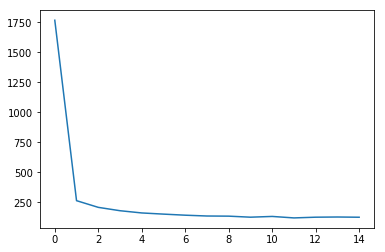

In [48]:
costs = []
for i in range(max_iter):
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest_ind)
            err = error_rate(prediction_val, Ytest)
            print("Cost / err at iteration i=%d, j=%d, cost_value: %.3f, error: %.3f" % (i, j, cost_val, err))
            costs.append(cost_val)

plt.plot(costs)
plt.show()